# Build an optimal neural-network classifier: step by step

We are going to implement an optimal neural network classifier to separate two Gaussian distributions.

Assume that $x$ follows one of the conditional probablity densities $p_0(x) = p(x|y=0)$ and $p_1(x) = p(x|y=1)$ on $\mathbb{R}^N$. To classify $x$, we minimize the logistic loss. More precisely, for a neural-network prediction $\hat{y}(x,\theta)$, we want to find an optimal $\theta$ such that the following loss $J$ is minimal,
$$ J (\theta) = - \mathbb{E}_{x \sim p_1 } [ \log( \hat{y}(x,\theta) )  ]-  \mathbb{E}_{x \sim p_0} [\log( 1- \hat{y}(x,\theta) ) ]. $$

In theory, it is known that the optimal $\hat{y}^\ast$ has the following form
$$
    \hat{y}^\ast(x) = \frac{1}{1 + e^{-f^\ast (x)} } , \quad f^\ast(x) = \log p_1(x) -\log p_0(x) .
$$
Note that if $p_1(x)$ is much larger than $p_0(x)$, then the prediction $\hat{y}^\ast(x)$ is close to $1$. This prediction is consistent with the optimal Bayes classifier (which predicts $1$ when $p_1(x) > p_0(x)$). Assume $p_0 = \mathcal{N}(\mu_0 , \sigma_0^2 I)$ and
$p_1 = \mathcal{N}(\mu_1 , \sigma_1^2 I)$, then $f^\ast(x)$ can be computed explicitly (TODO).

We are intersted in training a neural networks to approximate $f^\ast$. Based on the universal approximation theorem (https://www.cs.cmu.edu/~epxing/Class/10715/reading/Kornick_et_al.pdf), we first choose the following architecture (Definition 2.2)
$$
    f (x,\theta)  = \sum_{j=1}^q \beta_j \sigma ( w_{j}^\intercal x + b_j) + \beta_0, \quad
     \beta_j \in \mathbb{R}, w_{j} \in \mathbb{R}^N, b_j \in \mathbb{R} ,
$$
with the sigmoid non-linear activation function $\sigma$. The prediction  $ \hat{y}(x,\theta) = \sigma( f(x,\theta)) =1 / (1 + e^{ - f (x,\theta) } ) $. The differentiability of $\hat{y}(x,\theta)$ with respect to $\theta$ allows one to optimize the logistic loss $J(\theta)$.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from keras import optimizers
from keras.losses import BinaryCrossentropy
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import regularizers

2025-06-19 09:16:29.110417: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-19 09:16:29.114865: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-19 09:16:29.189081: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-19 09:16:29.190690: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-19 09:16:30.238408: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

# One-dimensional case

- Consider $N=1$, with $\mu_0= -1$, $\mu_1=1$, $\sigma_0=1$ and $\sigma_1=2$.
- The first dense layer computes $\sigma(Wx + b)$ where $W = [w_1^\intercal;\cdots;w_q^\intercal] \in \mathbb{R}^{q,N}$ and $b = (b_1 ,\cdots , b_q) \in \mathbb{R}^q$. We assume that the input $x$ is in the mini-batch form of size $N \times m$.

In [2]:
N = 1
mu0 = -1
mu1 = 1
sigma0 = 1
sigma1 = 2
q = 10
m = 2

## Use Keras to build the initial model

In [14]:
### TODO ###
model= Sequential()
model.add(Dense(q,activation='sigmoid',use_bias=True,input_shape=(N,)))
model.add(Dense(1,activation='sigmoid',use_bias=True))


### TODO ###

### Evaluation
- Before training, compare the initial model with the optimal prediction $\hat{y}^\ast$

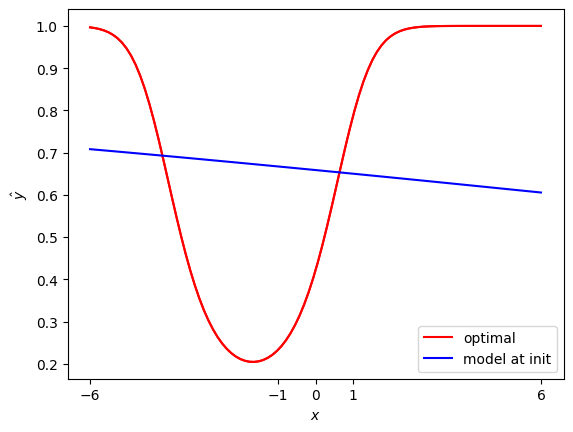

In [15]:
# compute along x in [-10,10]
# the function model(x) and \hat{y}^\ast


def opty_1d(x):
    # Compute \hat{y}^\ast(x) = 1/(1+e^(-f*(x)))
    ### TODO ###
    f_etoile = np.log(1/(sigma1*np.sqrt(2*np.pi)))-((x-mu1)/sigma1)**2/2 -(np.log(1/(sigma0*np.sqrt(2*np.pi)))-((x-mu0)/sigma0)**2/2)
    to_return = 1/(1+np.exp(-f_etoile))
    return to_return
    ### END TODO ###

def plot_y(model,model_label):
    m = 100
    x_arr = np.linspace(-6,6,m)
    y_arr_opt = opty_1d(x_arr)
    plt.plot(x_arr,y_arr_opt,'r')
    y_arr_model = model(x_arr.reshape((m,N)))[:,0]
    plt.plot(x_arr,y_arr_opt,'r',label='optimal')
    plt.plot(x_arr,y_arr_model,'b',label=model_label)
    plt.xticks([-6,-1,0,1,6])
    plt.legend()
    plt.ylabel('$\hat{y}$')
    plt.xlabel('$x$')

plot_y(model,'model at init')

### Implement generate_samples_1d

We are going to sample $m$ data points of $(x_i,y_i)$ from the distributions $p_0$ and $ p_1$.

The following function generate_samples_1d(m) returns $m$ i.i.d sample points in the 1d case.

In [ ]:
def generate_samples_1d(m):
    # case $N=1$, with $\mu_0= -1$, $\mu_1=1$, $\sigma_0=1$ and $\sigma_1=2$.
    """
    Arguments:
    m -- number of samples
    Retourne :
    X -- numpy array, shape (N,m)
    Y -- numpy array, shape (1,m)
    """
    X = np.zeros((N,m))
    Y = np.zeros((1,m))
    for i in range(m):
        # choose with 1/2 probability
        # sample x from p_0 or p_1
        ### TODO ###
        if np.random.rand()<1/2:
            X[:,i] = np.random.normal(loc=mu0, scale=sigma0, size=N)
            Y[0,i] = 0
        else:
            X[:,i] = np.random.normal(loc=mu1, scale=sigma1, size=N)
            Y[0,i] = 1
        ### TODO ###
    return X,Y


Assume that we have access to $m$ labels $(y_1,\cdots,y_m)$ and $m$ predictions $\hat{y}=(\hat{y}_1,\cdots,\hat{y}_m)$, and we are going to use the logistic loss (also known as the binary cross entropy)
$$
J = - \frac{1}{m} \sum_{i=1}^m ( \log(\hat{y}_i ) y_i +  \log(1-\hat{y}_i ) (1-y_i ) ).
$$

### Training
- Tune the number of (artificial) neurons $q \in \{10,100,1000\}$.

In [152]:
q = 10
### TODO ###
model= Sequential()
model.add(Dense(q,activation='sigmoid',use_bias=True,input_shape=(N,)))
model.add(Dense(1,activation='sigmoid',use_bias=True))

model.compile(
    optimizer=optimizers.Adam(),
    loss=BinaryCrossentropy(),
    metrics=['accuracy'],
)
### TODO ###

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

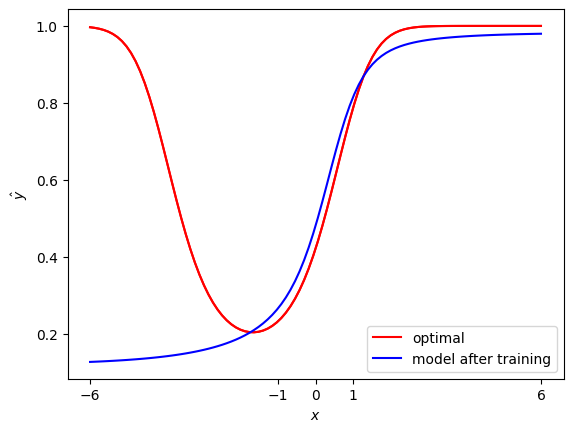

In [153]:
X_train, Y_train = generate_samples_1d(1000)

### TODO ###
model.fit(
    x=X_train.T,
    y=Y_train.T,
    epochs=100,
    batch_size=32, 
    verbose='0'   
)
### TODO ###

# Compare the function model(x) and \hat{y}^\ast
plot_y(model,'model after training')

Epoch 1/250
Epoch 2/250
Epoch 3/250
Epoch 4/250
Epoch 5/250
Epoch 6/250
Epoch 7/250
Epoch 8/250
Epoch 9/250
Epoch 10/250
Epoch 11/250
Epoch 12/250
Epoch 13/250
Epoch 14/250
Epoch 15/250
Epoch 16/250
Epoch 17/250
Epoch 18/250
Epoch 19/250
Epoch 20/250
Epoch 21/250
Epoch 22/250
Epoch 23/250
Epoch 24/250
Epoch 25/250
Epoch 26/250
Epoch 27/250
Epoch 28/250
Epoch 29/250
Epoch 30/250
Epoch 31/250
Epoch 32/250
Epoch 33/250
Epoch 34/250
Epoch 35/250
Epoch 36/250
Epoch 37/250
Epoch 38/250
Epoch 39/250
Epoch 40/250
Epoch 41/250
Epoch 42/250
Epoch 43/250
Epoch 44/250
Epoch 45/250
Epoch 46/250
Epoch 47/250
Epoch 48/250
Epoch 49/250
Epoch 50/250
Epoch 51/250
Epoch 52/250
Epoch 53/250
Epoch 54/250
Epoch 55/250
Epoch 56/250
Epoch 57/250
Epoch 58/250
Epoch 59/250
Epoch 60/250
Epoch 61/250
Epoch 62/250
Epoch 63/250
Epoch 64/250
Epoch 65/250
Epoch 66/250
Epoch 67/250
Epoch 68/250
Epoch 69/250
Epoch 70/250
Epoch 71/250
Epoch 72/250
Epoch 73/250
Epoch 74/250
Epoch 75/250
Epoch 76/250
Epoch 77/250
Epoch 78

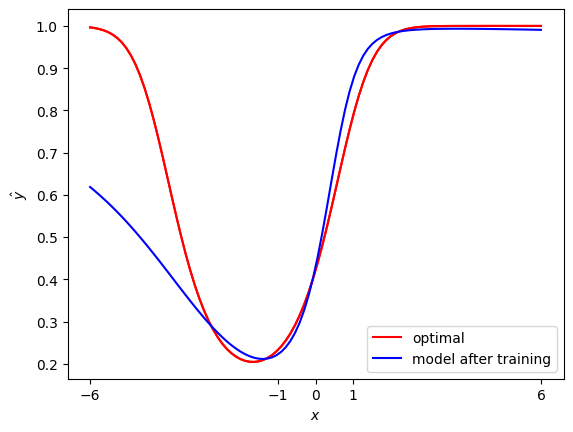

In [19]:
q = 100
### TODO ###
model= Sequential()
model.add(Dense(q,activation='sigmoid',use_bias=True,input_shape=(N,)))
model.add(Dense(1,activation='sigmoid',use_bias=True))

model.compile(
    optimizer=optimizers.Adam(),
    loss=BinaryCrossentropy(),
    metrics=['accuracy'],
)
### TODO ###
X_train, Y_train = generate_samples_1d(1000)

### TODO ###
model.fit(
    x=X_train.T,
    y=Y_train.T,
    epochs=250,
    batch_size=32,  
    verbose='0'   
)
### TODO ###

# Compare the function model(x) and \hat{y}^\ast
plot_y(model,'model after training')

Epoch 1/250
Epoch 2/250
Epoch 3/250
Epoch 4/250
Epoch 5/250
Epoch 6/250
Epoch 7/250
Epoch 8/250
Epoch 9/250
Epoch 10/250
Epoch 11/250
Epoch 12/250
Epoch 13/250
Epoch 14/250
Epoch 15/250
Epoch 16/250
Epoch 17/250
Epoch 18/250
Epoch 19/250
Epoch 20/250
Epoch 21/250
Epoch 22/250
Epoch 23/250
Epoch 24/250
Epoch 25/250
Epoch 26/250
Epoch 27/250
Epoch 28/250
Epoch 29/250
Epoch 30/250
Epoch 31/250
Epoch 32/250
Epoch 33/250
Epoch 34/250
Epoch 35/250
Epoch 36/250
Epoch 37/250
Epoch 38/250
Epoch 39/250
Epoch 40/250
Epoch 41/250
Epoch 42/250
Epoch 43/250
Epoch 44/250
Epoch 45/250
Epoch 46/250
Epoch 47/250
Epoch 48/250
Epoch 49/250
Epoch 50/250
Epoch 51/250
Epoch 52/250
Epoch 53/250
Epoch 54/250
Epoch 55/250
Epoch 56/250
Epoch 57/250
Epoch 58/250
Epoch 59/250
Epoch 60/250
Epoch 61/250
Epoch 62/250
Epoch 63/250
Epoch 64/250
Epoch 65/250
Epoch 66/250
Epoch 67/250
Epoch 68/250
Epoch 69/250
Epoch 70/250
Epoch 71/250
Epoch 72/250
Epoch 73/250
Epoch 74/250
Epoch 75/250
Epoch 76/250
Epoch 77/250
Epoch 78

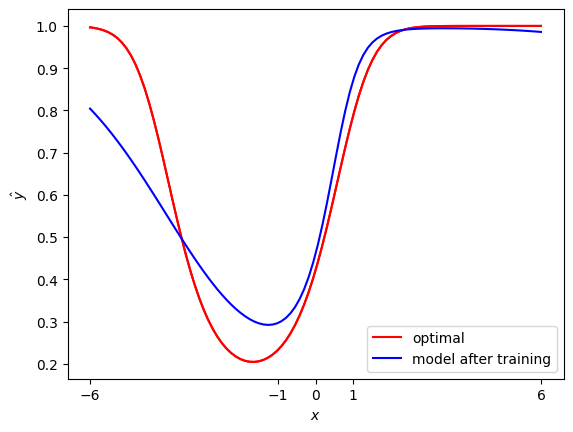

In [20]:
q = 1000
### TODO ###
model= Sequential()
model.add(Dense(q,activation='sigmoid',use_bias=True,input_shape=(N,)))
model.add(Dense(1,activation='sigmoid',use_bias=True))

model.compile(
    optimizer=optimizers.Adam(),
    loss=BinaryCrossentropy(),
    metrics=['accuracy'],
)
### TODO ###
X_train, Y_train = generate_samples_1d(1000)

### TODO ###
model.fit(
    x=X_train.T,
    y=Y_train.T,
    epochs=250,
    batch_size=32,  
    verbose='0'   
)
### TODO ###

# Compare the function model(x) and \hat{y}^\ast
plot_y(model,'model after training')

## Use Keras to build the $\Sigma \Pi$ model

Based on the universal approximation theorem (https://www.cs.cmu.edu/~epxing/Class/10715/reading/Kornick_et_al.pdf), we now choose the following architecture (Definition 2.4)
$$
    f (x,\theta)  = \sum_{j=1}^q \beta_j \prod_{i=1}^k \sigma ( w_{j i}^\intercal x + b_{j i}) + \beta_0, \quad
     \beta_j \in \mathbb{R}, w_{ji} \in \mathbb{R}^N, b_{ji} \in \mathbb{R} ,
$$
with the sigmoid non-linear activation function $\sigma$. The prediction  $ \hat{y}(x,\theta) = \sigma( f(x,\theta)) =1 / (1 + e^{ - f (x,\theta) } ) $.

### Implementation of a product layer

In [135]:
class ElementwiseProd(tf.keras.layers.Layer):
    def __init__(self, q, k, act='sigmoid', **kwargs):
        super().__init__(**kwargs)
        self.q = q
        self.k = k
        self.act = tf.keras.activations.get(act)
        self.hidden_layers = []  # Liste de k couches Dense (chacune de taille q)
        for _ in range(self.k):
            self.hidden_layers.append(
                tf.keras.layers.Dense(self.q, activation=self.act)
            )        
    
    def call(self, inputs):
        # Multiplie les k activations entre elles (élément par élément)
        output = tf.ones((tf.shape(inputs)[0], self.q))
        for layer in self.hidden_layers:
            out = layer(inputs)
            output *= out  # Produit élément par élément
        return output


### Test

In [148]:
N = 1
q = 10
k = 3
activation = 'sigmoid'

inputs = tf.keras.Input(shape=(N,))
prod_layer = ElementwiseProd(q=q, k=k, act=activation)
product = prod_layer(inputs)
model = tf.keras.Model(inputs=inputs, outputs=product)

x_test = np.random.randn(1, N).astype(np.float32)
y_model = model(x_test).numpy()

### TODO ###
W = []
b = []

for layer in range(k):
    w_i,b_i= prod_layer.hidden_layers[layer].get_weights()
    W.append(w_i)
    b.append(b_i)

### TODO ###
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

outputs = []
for i in range(k):
    y = x_test @ W[i] + b[i]
    y = sigmoid(y)
    outputs.append(y)

y_true = outputs[0]
for i in range(1, k):
    y_true *= outputs[i]

print("Résultat modèle Keras")
print(y_model)
print("Résultat calculé")
print(y_true)
print("Erreur relative max")
print(np.max(np.abs(y_model - y_true)/np.abs(y_true)))

Résultat modèle Keras
[[0.11584599 0.120819   0.11797656 0.12890325 0.12038136 0.118256
  0.12630765 0.12228237 0.11860942 0.11385484]]
Résultat calculé
[[0.115846   0.12081901 0.11797657 0.12890327 0.12038136 0.11825601
  0.12630767 0.12228237 0.11860944 0.11385486]]
Erreur relative max
1.9631786e-07


### Model definition



In [158]:
### TODO ###
N = 1
q = 10
k = 5
activation = 'sigmoid'
model= Sequential()
model.add(ElementwiseProd(q=q, k=k, act=activation))
model.add(Dense(1,activation='sigmoid',use_bias=True))
### TODO ###

### Training

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

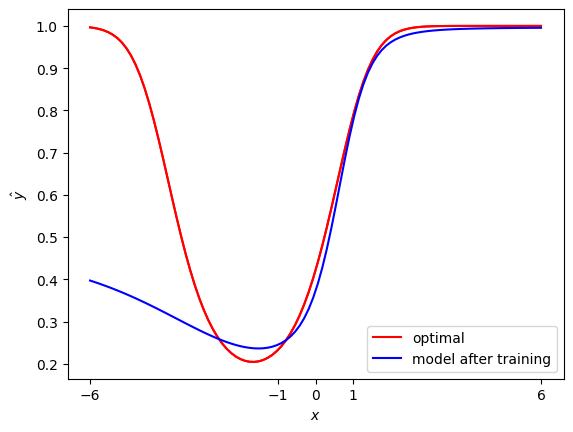

In [159]:
### TODO ###
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=BinaryCrossentropy(),
    metrics=['accuracy'],
)
### TODO ###
X_train, Y_train = generate_samples_1d(1000)

### TODO ###
model.fit(
    x=X_train.T,
    y=Y_train.T,
    epochs=100,
    batch_size=32,  
    verbose='0'   
)
### TODO ###

# Compare the function model(x) and \hat{y}^\ast
plot_y(model,'model after training')